# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

- 한국어 텍스트의 감정 분석
활용한 데이터셋은 네이버 영화의 댓글을 모아 구성하였다.     
[출처:Naver sentiment movie corpus](https://github.com/e9t/nsmc)

- Naver sentiment movie corpus는 195,339개의 한국어로 작성된 영화 리뷰 텍스트로 구성되어 있으며, 긍정은 1, 부정은 0의 라벨이 달려 있다.

## 1. 데이터 준비와 확인
필요한 패키지를 import하고 데이터를 불러온다. 데이터가 제대로 불려왔는지 확인하기 위해 train data의 첫 5행을 출력해 보았다. 이 데어터는 id, 리뷰 내용이 담긴 document, 리뷰가 부정(0)인지 긍정(1)인지 나타내는 label로 이루어져 있다. 

In [1]:
# import 패키지
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')
print(len(train_data), len(test_data))

# train_data의 첫 5행 확인
train_data.head()


150000 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성
nsmc 데이터셋은 가공되지 않은 텍스트 파일이므로 data_loader를 만들어야 한다. 이를 위해 1) 데이터의 중복 제거, 2) NaN 결측치 제거 3) 한국어 토크나이저로 토근화 4) 불용어(stopwords) 제거 5) 사전 word_to_index 구성 6) 텍스트 스트링을 사전 인덱스 스트링으로 변환 7) X_train, y_train, X_test, y_test, word_to_index 리턴 을 해야 한다. 

참고> 토큰화: 주어진 코퍼스에서 토큰(token)의 단위로 나누는 작업이다. 

In [2]:
# 데이터 로더 구성
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']  # 불용어

def load_data(train_data, test_data, num_words=10000):    # 호출시 단어사전에 등재할 단어의 개수
    train_data.drop_duplicates(subset=['document'], inplace=True)   # 데이터의 중복 제거   
    train_data = train_data.dropna(how = 'any')                     # NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)                          # 한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)                          # 한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)           # 특수문자 4개 제외한 단어 수 세기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}              # 사전(word_to_index) 구성

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

주어진 데이터를 encode한 텍스트 데이터로 바꾸었다. 

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한 번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

데이터의 실제 예시를 확인해 보았다. 

In [6]:
print(X_train[0])
print('1번째 리뷰의 라벨: ', y_train[0])
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print(index_to_word[5])
print(word_to_index['재미'])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
1번째 리뷰의 라벨:  0
1번째 리뷰 문장 길이:  10
영화
94


encode된 텍스트를 decode하였다. 

In [7]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한 번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

decode한 문장의 라벨이 0이고, 실제 문장의 내용이 부정적이므로 encode된 텍스트가 정상적으로 decode되었음을 알 수 있다. 

In [8]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 3. 모델구성을 위한 데이터 분석 및 가공

### 1) 데이터셋 내 문장 길이 분포 
데이터의 실제 예시를 확인해 보았다. 다운로드 받은 corpus가 데이터로더 구성에 의해 숫자로 encode된 텍스트 데이터로 변화되었음을 알 수 있다. 

In [9]:
# 데이터 확인
print(X_train[0])  # 1번째 리뷰 데이터
print('라벨: ', y_train[0])  # 1번째 리뷰 데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


### 2) 적절한 최대 문장 길이 지정 
문장 최대 길이 maxlen의 값 설정이 전체 모델 성능에 영향을 미치므로 적절한 값을 찾기 위해 데이터셋의 분포를 확인하였다. 아래의 경우, 가장 긴 리뷰의 길이는 41이고, 전체 데이터의 길이는 평균 15, 최대 길이는 113임을 알 수 있다. 따라서 다음 순서는 모델이 처리할 수 있도록 샘플의 길이를 동일하게 맞춰주는 것이다. 지금은 전체 샘플 중에서 길이가 41 이하인 샘플의 비율은 93.4%이다.

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
padding은 서로 다른 길이의 샘플들의 길이를 맞춰주는 작업이다. padding 방식을 문장 뒷쪽(post)와 앞쪽(pre) 중 어느 쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용시 성능 차이가 발생한다. 먼저 문장 뒤쪽으로 padding을 해 보았다. 모든 샘플의 길이를 뒤쪽에서부터  특정 길이(maxlen)만큼 정하였다.

In [11]:
# padding 방식에 따른 RNN 비교
# post
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0
pad_sequences maxlen :  41
전체 문장의 0.0%가 maxlen 설정값 이내에 포함됩니다. 


## 4-1. 모델구성 및 validation set 구성
첫번째로 RNN 모델을 설계해 보았다.

#### 1) Validation set 구성       
모델 훈련 전에 훈련용 데이터셋 중 5천건을 분리하여 검증셋으로 사용하였다. 1만건을 검증셋으로 사용할 때보다 5천건을 하였을 때, 아주 조금 더 정확도가 높아져서 5천건으로 검증셋을 정하였다. 

In [13]:
# validation set 5000건 분리
X_val = X_train[:5000]   
y_val = y_train[:5000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[5000:]  
partial_y_train = y_train[5000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(141182, 41)
(141182,)


#### 2)  모델 설계
LSTM 레이어를 사용한 RNN 모델을 사용하였다. LSTM state 벡터의 차원수는 8이고, 최종 출력은 긍정/부정으로 나타난다. LSTM state 벡터의 차원수를 16으로 증가시켜 보았으나 큰 차이를 보이지 않았다. 

In [14]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNNmodel 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM 레이어를 사용하였다. LSTM state 벡터의 차원수는 8
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 3488      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


## 5-1. 모델 훈련 개시

#### 1) 모델 학습
좋은 결과를 얻도록 epoch를 변경하여 모델을 학습해 보았다.

In [15]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
276/276 [==============================] - 4s 13ms/step - loss: 0.4773 - accuracy: 0.7820 - val_loss: 0.3491 - val_accuracy: 0.8548
Epoch 2/5
276/276 [==============================] - 3s 12ms/step - loss: 0.3396 - accuracy: 0.8579 - val_loss: 0.3348 - val_accuracy: 0.8602
Epoch 3/5
276/276 [==============================] - 3s 12ms/step - loss: 0.3109 - accuracy: 0.8685 - val_loss: 0.3347 - val_accuracy: 0.8574
Epoch 4/5
276/276 [==============================] - 3s 12ms/step - loss: 0.2942 - accuracy: 0.8731 - val_loss: 0.3379 - val_accuracy: 0.8498
Epoch 5/5
276/276 [==============================] - 3s 12ms/step - loss: 0.2793 - accuracy: 0.8781 - val_loss: 0.3503 - val_accuracy: 0.8570


#### 2) 테스트 셋으로 평가

In [16]:
# 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3685 - accuracy: 0.8474
[0.36847400665283203, 0.8473869562149048]


## 6-1. Loss, Accuracy 그래프 시각화
model.fit() 과정에서 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있다. 이 데이터를 그래프로 그려 수행한 딥러닝 학습이 잘 되었는지, 오버피팅/언더피팅하지 않았는지 등을 파악한다. 

#### 1) Loss 그래프 시각화
Loss 그래프 시각화를 통해 몇 epoch까지 트레이닝이 적절한지 최적점을 추정할 수 있다. validation loss의 그래프가 train loss와의 사이가 벌어지면 더 이상의 트레이닝은 무의미해진다.      
그래프로 보았을 때 학습 로스와 검증 로스의 사이가 점점 벌어져서 epoch를 5로 정하였다. 

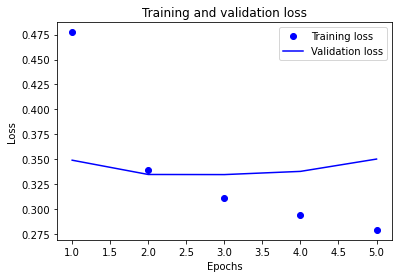

In [17]:
# epoch에 따른 training and validation loss 그래프 그리기

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 2) Accuracy 그래프 시각화
Accuray 그래프를 통해서도 몇 epoch까지의 트레이닝이 적절한지 추정할 수 있다. Loss 그래프와 마찬가지로 두 그래프가 점점 벌어지는 것을 알 수 있다.

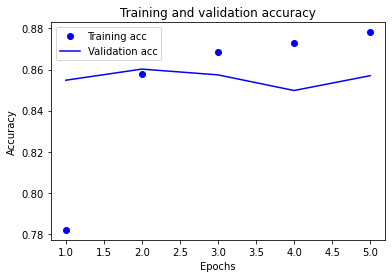

In [18]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7-1. 학습된 Embedding 레이어 분석
워드 임베딩(word embedding)은 라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 향상시키는 자연어처리 기법으로, 단어의 특성을 저차원 벡터값으로 표현한다. RNN 모델의 첫 번째 레이어가 Embedding 레이어였고, 이 레이어는 갖고 있는 사전의 단어 개수 X 워드벡터 사이즈만큼의 크기를 가진 학습 파라미터였다. 만약 위에서 시도한 감성분류 모델인 RNN 모델이 학습이 잘 되었다면 embedding 레이어에 학습된 워드 벡터들도 의미 공간 상에 유의미한 형태로 학습되었을 것이다. 그러므로 학습된 embedding 레이어를 분석해 보았다. 

In [19]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


학습한 Embedding 파라미터를 파일에 써서 저장하고, 워드 벡터의 차원수를 어휘 사전 크기(10,000)에서 특수문자 4개를 뺀 사이즈로 타이틀을 썼다. 단어 개수 만큼의 워드 벡터를 파일에 기록하였다.

In [20]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

gensim에서 제공하는 패키지를 사용하여 Embedding 파라미터를 word vector로 활용하였다. 

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.02672638, -0.03167142, -0.2080766 , -0.11701433,  0.09696403,
       -0.05638734,  0.0729093 , -0.01383703,  0.00842475,  0.00929171,
        0.02329517, -0.00100162, -0.02012034, -0.01756208,  0.03281879,
       -0.03173911,  0.04711556,  0.00846714, -0.04159535,  0.05846025,
       -0.04085942,  0.05218532, -0.01775444, -0.05111843, -0.00251929,
        0.03821387,  0.01881933, -0.03710107,  0.01702517, -0.0151973 ,
        0.02208129, -0.06620885, -0.00131984, -0.00229398,  0.00434833,
       -0.00250394,  0.01460265,  0.07510555,  0.02889573, -0.04915622,
       -0.0050952 ,  0.04495397,  0.01670543, -0.04162934, -0.00299976,
        0.01513339, -0.00692585, -0.03391766,  0.01495557, -0.02506282,
        0.02068501,  0.01472061, -0.06479575, -0.00349406, -0.02002282,
       -0.04350447,  0.04912685, -0.03063585, -0.03656757,  0.03472672,
        0.01688985,  0.07045873, -0.02477636,  0.050855  ,  0.02329415,
       -0.01185596,  0.003334  , -0.04391083, -0.05446913,  0.05

단어 하나를 주고 그 단어와 가장 유사한 단어의 유사도를 확인하여 워드 벡터가 의미벡터 공간 상에 유의미하게 학습되었는지 확인하였다. 

In [22]:
# 워드 벡터가 의미벡터 공간 상에 유의미하게 학습되었는지 확인
# 단어와 그 단어와 유사한 단어와의 유사도 확인
word_vectors.similar_by_word("재미")

[('캐', 0.8604620099067688),
 ('완전', 0.8406689167022705),
 ('넘', 0.8261874914169312),
 ('초', 0.8193526268005371),
 ('이렇게', 0.8190044164657593),
 ('기대', 0.818013608455658),
 ('긴장감', 0.8076725006103516),
 ('이건', 0.8004950284957886),
 ('매우', 0.8004699349403381),
 ('졸라', 0.7988394498825073)]

## 4-1-1. padding을 'pre'로
이번에는 문장 앞쪽('pre')으로 padding하여 성능이 얼마나 차이가 나는지 확인해 보았다. 

In [23]:
# padding 방식에 따른 RNN 비교
# pre
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [24]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0
pad_sequences maxlen :  41
전체 문장의 0.0%가 maxlen 설정값 이내에 포함됩니다. 


## 4-1-1. 모델구성 및 validation set 구성

#### 1) Validation set 구성       
모델 훈련 전에 훈련용 데이터셋 중 5000건을 분리하여 검증셋으로 사용하였다. 

In [25]:
# validation set 5000건 분리
X_val = X_train[:5000]   
y_val = y_train[:5000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[5000:]  
partial_y_train = y_train[5000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(141182, 41)
(141182,)


#### 2)  모델 설계

In [26]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNNmodel 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM 레이어를 사용하였더. LSTM state 벡터의 차원수는 8
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


## 5-1-1. 모델 훈련 개시

#### 1) 모델 학습

In [27]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=6 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/6
276/276 [==============================] - 4s 13ms/step - loss: 0.5636 - accuracy: 0.6700 - val_loss: 0.3570 - val_accuracy: 0.8506
Epoch 2/6
276/276 [==============================] - 3s 12ms/step - loss: 0.3440 - accuracy: 0.8543 - val_loss: 0.3282 - val_accuracy: 0.8578
Epoch 3/6
276/276 [==============================] - 3s 12ms/step - loss: 0.3087 - accuracy: 0.8700 - val_loss: 0.3286 - val_accuracy: 0.8602
Epoch 4/6
276/276 [==============================] - 3s 12ms/step - loss: 0.2907 - accuracy: 0.8777 - val_loss: 0.3409 - val_accuracy: 0.8594
Epoch 5/6
276/276 [==============================] - 3s 12ms/step - loss: 0.2742 - accuracy: 0.8854 - val_loss: 0.3391 - val_accuracy: 0.8532
Epoch 6/6
276/276 [==============================] - 3s 12ms/step - loss: 0.2588 - accuracy: 0.8936 - val_loss: 0.3496 - val_accuracy: 0.8538


#### 2) 테스트 셋으로 평가

In [28]:
# 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3657 - accuracy: 0.8492
[0.36574679613113403, 0.8492178320884705]


padding을 문장 뒤쪽(post)에서 했을 때는 loss가 36.85%, accuracy가 84.74%로 나왔고, 앞쪽(pre)에서 했을 때는 loss가 36.57%, accuracy가 84.94%로 나왔다. 아주 작은 차이지만 문장 앞쪽에서 padding을 했을 때 정확도가 조금 증가하는 것을 볼 수 있다. 

## 6-1-1. Loss, Accuracy 그래프 시각화

#### 1) Loss 그래프 시각화

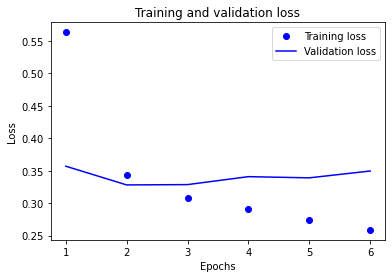

In [29]:
# epoch에 따른 training and validation loss 그래프 그리기

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 2) Accuracy 그래프 시각화

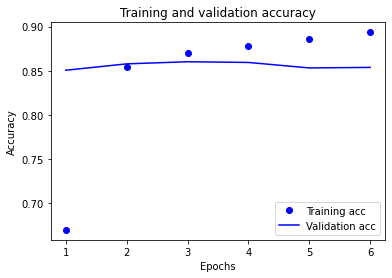

In [30]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7-1-1. 학습된 Embedding 레이어 분석

In [31]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


- 학습한 Embedding 파라미터 저장

In [32]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- Embedding 파라미터를 word vector로 활용

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.14422019,  0.03949201, -0.05648529, -0.02061285,  0.01116042,
       -0.06671419,  0.00282237,  0.04049534,  0.04728917,  0.06528499,
       -0.04553739,  0.00833018, -0.01646511, -0.02806476,  0.07192148,
       -0.01572937,  0.04855216, -0.0368204 , -0.10324572,  0.06506828,
        0.09732473, -0.04015163, -0.01420206, -0.02253484,  0.05948599,
       -0.03833088, -0.0470791 ,  0.00257749, -0.00499138,  0.03807172,
       -0.03237396,  0.04943783,  0.09755465,  0.12337416,  0.06793916,
        0.00782282,  0.11047988, -0.02797821,  0.00723208, -0.01186652,
       -0.05595469,  0.03204954,  0.01625542, -0.08808373,  0.00881109,
       -0.01959412,  0.14862894, -0.03644729,  0.08637363,  0.05827332,
        0.05817017,  0.02271741, -0.01776505,  0.05727351, -0.01834229,
       -0.07104834, -0.06084378,  0.00044718,  0.04328982, -0.06407759,
       -0.08130484, -0.06222598, -0.02320374, -0.02908036,  0.11985998,
        0.02216414, -0.05092562,  0.09046831, -0.0407292 , -0.04

In [34]:
# 워드 벡터가 의미벡터 공간 상에 유의미하게 학습되었는지 확인
# 단어와 그 단어와 유사한 단어와의 유사도 확인
word_vectors.similar_by_word("재미")

[('기대', 0.8025248646736145),
 ('완전', 0.7885040640830994),
 ('긴장감', 0.7829486131668091),
 ('이렇게', 0.7791324853897095),
 ('매력', 0.7408839464187622),
 ('반전', 0.7321121692657471),
 ('주장', 0.7182854413986206),
 ('가치', 0.7131662964820862),
 ('볼수록', 0.7041880488395691),
 ('아무튼', 0.7018340826034546)]

## 4-2. 모델구성 및 validation set 구성
두 번째로 1-D CNN을 이용하였다. 
1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝하면서 7단어 이내에서 발견되는 특징을 추출하여 문장을 분류한다. RNN 계열보다 병렬처리가 효율적이므로 학습속도가 훨씬 빠르게 진행된다는 장점이 있다. 
따라서 1-D CNN을 사용하여 문장을 얼마나 잘 분류하고, 학습이 RNN보다 얼마나 빠른지 확인해 보았다. 

#### 1) Validation set 구성       
모델 훈련 전에 훈련용 데이터셋 중 5000건을 분리하여 검증셋으로 사용하였다. 

In [35]:
# validation set 5000건 분리
X_val = X_train[:5000]   
y_val = y_train[:5000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[5000:]  
partial_y_train = y_train[5000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(141182, 41)
(141182,)


#### 2) 1-D CNN 모델 설계

In [36]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 1-D CNN 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

## 5-2. 모델 훈련 개시

#### 1) 모델 학습

In [37]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 보자. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
276/276 [==============================] - 10s 36ms/step - loss: 0.4448 - accuracy: 0.7898 - val_loss: 0.3367 - val_accuracy: 0.8578
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.3078 - accuracy: 0.8708 - val_loss: 0.3300 - val_accuracy: 0.8578
Epoch 3/3
276/276 [==============================] - 3s 12ms/step - loss: 0.2577 - accuracy: 0.8963 - val_loss: 0.3420 - val_accuracy: 0.8532


#### 2) 테스트 셋으로 평가

In [38]:
# 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3461 - accuracy: 0.8526
[0.3461321294307709, 0.8525540828704834]


패딩을 앞쪽에서 하고, 같은 epoch(5)를 사용했을 때, 대부분 학습 속도는 1-D CNN이 더 빠르지만 정확도는 RNN이 더 높게 나왔다(1-D CNN이 1초, RNN이 2~3초가 나왔다). 그러나 마지막으로 다시 한 번 돌려보았더니 1-D CNN의 속도가 RNN보다 느리고 성능은 RNN보다 좋게 나와서 당황했다. 왜 이렇게 나왔는지 이유를 잘 모르겠다. 

## 6-2. Loss, Accuracy 그래프 시각화

#### 1) Loss 그래프 시각화
아래의 그래프에서 보면 training과 validation loss가 학습 3번 이후 크게 벌어지나 학습을 3번 시키면 두 그래프가 처음부터 벌어지는 결과가 나와서 학습 횟수를 5번으로 정하였다.

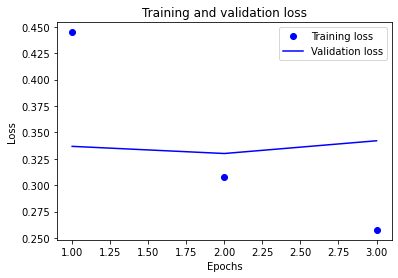

In [39]:
# epoch에 따른 training and validation loss 그래프 그리기

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 2) Accuracy 그래프 시각화

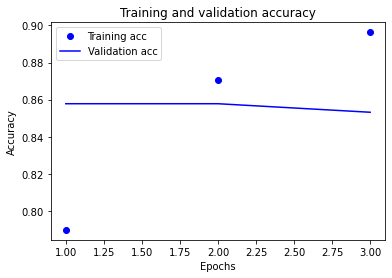

In [40]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7-2. 학습된 Embedding 레이어 분석

In [41]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


- 학습한 Embedding 파라미터 저장

In [42]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- Embedding 파라미터를 word vector로 활용

In [43]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.05257164,  0.00962681,  0.05088608, -0.04647012, -0.03269146,
       -0.04289315,  0.06862747, -0.02052895,  0.07098629,  0.01505431,
       -0.09330776,  0.01441629,  0.07751474,  0.06020313,  0.01154705,
        0.00384257,  0.00793244, -0.02486027,  0.01548035, -0.01863885,
       -0.05046687, -0.00459868,  0.02078035, -0.02795326,  0.03453894,
       -0.00877364, -0.03349088,  0.00708036,  0.05976178, -0.08076786,
       -0.07140872,  0.03906745,  0.04246771, -0.07576357, -0.0003602 ,
       -0.0541661 ,  0.06831852, -0.04152757, -0.04271421,  0.00074254,
        0.00306814, -0.02913146,  0.10373814, -0.01696125, -0.03203768,
       -0.01818311,  0.0160855 ,  0.04340917,  0.00492813, -0.11572613,
       -0.04904407, -0.00744356,  0.01419735,  0.0079537 ,  0.02121387,
        0.00747462, -0.05118033,  0.02039484,  0.00611439, -0.03257111,
       -0.04046752,  0.04170091, -0.01611656, -0.04564838, -0.07215141,
        0.0101387 , -0.00059401, -0.0177455 ,  0.01601594,  0.02

In [44]:
# 워드 벡터가 의미벡터 공간 상에 유의미하게 학습되었는지 확인
# 단어와 그 단어와 유사한 단어와의 유사도 확인
word_vectors.similar_by_word("재미")

[('감동', 0.5339151620864868),
 ('존재감', 0.530790388584137),
 ('졸라', 0.5270810127258301),
 ('가장', 0.5208884477615356),
 ('가치', 0.4913490116596222),
 ('너무', 0.4894264042377472),
 ('제미', 0.4886665940284729),
 ('완전', 0.48593464493751526),
 ('진짜', 0.4797467589378357),
 ('긴장감', 0.4734327495098114)]

## 4-3. 모델구성 및 validation set 구성
세 번째로 GlobalMaxPooling1D() 레이어 하나만 사용했다. 이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 의외로 성능이 잘 나올 수도 있다.

#### 1) Validation set 구성       
모델 훈련 전에 훈련용 데이터셋 중 5000건을 분리하여 검증셋으로 사용하였다. 

In [45]:
# validation set 5000건 분리
X_val = X_train[:5000]   
y_val = y_train[:5000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[5000:]  
partial_y_train = y_train[5000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(141182, 41)
(141182,)


#### 2) 모델 설계

In [46]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,011,361
Trainable params: 1,011,361
Non-trainable params: 0
_________________________________________________________________


## 5-3. 모델 훈련 개시

#### 1) 모델 학습

In [47]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
276/276 [==============================] - 3s 12ms/step - loss: 0.4344 - accuracy: 0.8052 - val_loss: 0.3343 - val_accuracy: 0.8560
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.3067 - accuracy: 0.8711 - val_loss: 0.3258 - val_accuracy: 0.8636
Epoch 3/3
276/276 [==============================] - 3s 11ms/step - loss: 0.2636 - accuracy: 0.8927 - val_loss: 0.3270 - val_accuracy: 0.8616


#### 2) 테스트 셋으로 평가

In [48]:
# 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3357 - accuracy: 0.8592
[0.3356950879096985, 0.8591858744621277]


## 6-3. Loss, Accuracy 그래프 시각화

#### 1) Loss 그래프 시각화

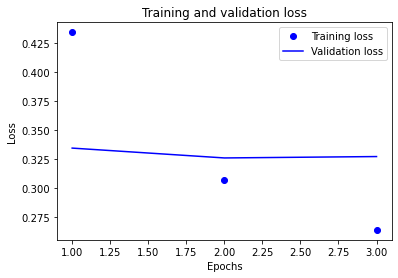

In [49]:
# epoch에 따른 training and validation loss 그래프 그리기

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 2) Accuracy 그래프 시각화

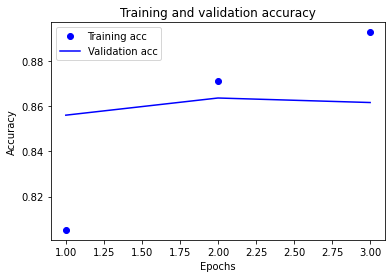

In [50]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7-3. 학습된 Embedding 레이어 분석

In [51]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [52]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- Embedding 파라미터 확인

In [88]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-2.95980964e-02,  8.46659988e-02, -2.82300487e-02,  1.30987121e-02,
        2.47807596e-02,  1.51663553e-03,  5.73088415e-02,  2.51229871e-02,
        5.16057648e-02, -2.50410382e-02,  4.67068069e-02,  8.41103029e-03,
        6.53791353e-02,  4.85230051e-02, -5.91950901e-02,  3.42520438e-02,
        3.03955469e-02,  2.36160681e-03, -9.67650861e-02, -1.41409589e-02,
       -2.58315504e-02, -4.37065177e-02, -5.85651211e-02,  5.04226051e-02,
       -5.47259785e-02, -2.05070954e-02,  2.47060861e-02,  6.19252585e-02,
       -8.25140532e-03,  9.82583873e-03, -3.58943753e-02,  5.12865856e-02,
       -7.46612577e-03, -5.14088795e-02, -2.04262473e-02,  1.79606173e-02,
        1.32485628e-04,  3.88880521e-02,  3.62907760e-02, -3.26158069e-02,
        5.93718700e-02,  2.34005935e-02, -3.97598632e-02, -4.99780327e-02,
       -4.46972102e-02,  5.22049777e-02,  8.35817493e-03, -3.77447195e-02,
       -1.45040378e-02,  4.17929702e-02, -4.37087752e-02,  1.88443884e-02,
        1.08012538e-02,  

- Embedding 파라미터를 word vector로 활용

In [54]:
# 워드 벡터가 의미벡터 공간 상에 유의미하게 학습되었는지 확인
# 단어와 그 단어와 유사한 단어와의 유사도 확인
word_vectors.similar_by_word("재미")

[('취향', 0.6770460605621338),
 ('제미', 0.6570246815681458),
 ('이리', 0.6540573835372925),
 ('임팩트', 0.652675211429596),
 ('미', 0.6351391673088074),
 ('짱짱', 0.6347969174385071),
 ('매우', 0.5963135361671448),
 ('후속작', 0.5937454104423523),
 ('마징가', 0.5845733880996704),
 ('드문', 0.5801931619644165)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선
사전학습된 워드 임베딩 모델인 한국어 Word2Vec([여기](https://github.com/Kyubyong/wordvectors))을 활용하여 모델의 성능을 개선해 보았다. 

### 1)  사전 훈련된 한국어 Word2Vec 모델 로드
여러 가지 사전 훈련된 한국어 모델을 사용하였다. ko.bin 파일의 경우, LMS에 나온 코드를 사용하니 에러 메시지가 나왔다. 위키닥스를 참고하여 한국어 Word2Vec 모델을 ```model = gensim.models.Word2Vec.load('ko.bin 파일의 경로')```를 써서 로드하였다. [참고: wikidocs](https://wikidocs.net/50739)
그러나 ko.vec파일은 위의 코드를 쓰면 에러 메시지가 나와서 영어 Word2Vec 임베딩과 같은 코드를 사용하였다. 
ko.bin과 ko.vec을 비교해 보았을 때, ko.vec파일이 성능이 조금 더 좋아서 ko.vec파일을 사용했다. 

In [55]:
import gensim 
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.vec'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False, limit=1000000)
vector = word2vec['영화']
vector   # 이 데이터에 대해 분석해야 한다.

array([ 1.8125e-01, -2.5123e-01,  1.7876e-01, -1.3278e-02, -3.9651e-01,
       -5.1186e-01,  6.3876e-01, -1.4718e-01,  2.6356e-02,  1.3623e-01,
        3.3384e-01, -1.2785e-02,  3.6469e-01, -8.6068e-02,  4.0517e-02,
        3.6734e-01,  3.1056e-01,  3.3490e-01, -3.1863e-01, -5.5490e-02,
       -4.7026e-01,  1.3183e-01,  1.8501e-01, -3.3728e-01,  1.2701e-01,
        9.4333e-02, -2.0064e-01,  3.7874e-01,  4.2810e-01,  1.2058e-01,
        1.6202e-01,  3.1488e-01,  2.7374e-01, -1.0546e-01,  1.7608e-01,
       -1.1968e-01, -4.1559e-02, -3.8206e-01, -2.4690e-01, -1.0811e-01,
        3.1043e-01,  1.8582e-01,  6.1235e-02,  1.6734e-01, -1.0168e-01,
       -2.0457e-01,  2.3861e-01,  3.2822e-01,  2.3092e-01, -4.1230e-02,
        1.8685e-01, -9.5627e-02,  2.1094e-01,  1.8469e-01,  5.7604e-01,
        2.7050e-01,  2.6731e-01, -1.2759e-02,  2.0977e-01, -8.1527e-02,
        2.1588e-01, -2.9591e-01, -2.4410e-01, -2.9915e-01,  9.2866e-02,
        1.8276e-01, -1.5060e-01,  6.4768e-02, -1.0031e-01, -4.29

벡터의 길이를 출력해보니 총 200개의 워드 벡터임을 알 수 있다. 

In [56]:
print(len(vector))

200


### 2) 모델의 유사도 확인
'영화'와 유사한 단어를 찾아 보았더니 한국어 word2vec에서 제공하는 워드 임베딩 벡터끼리는 의미적 유사도가 높게 나왔다. 그러나 '재미'로 해보았을 때는 그다지 높게 나오지 않는 것을 발견했다(10개 중 6개만 유사함.).

In [86]:
# 의미적 유사도 확인
word2vec.similar_by_word("영화")

[('개봉', 0.7001899480819702),
 ('영화인', 0.6775298118591309),
 ('다큐멘터리', 0.673824667930603),
 ('영화화하', 0.6737728118896484),
 ('영화사', 0.6599559783935547),
 ('영화감독', 0.6589449644088745),
 ('드라마', 0.6550132036209106),
 ('각색', 0.6526349186897278),
 ('뮤지컬', 0.6512709856033325),
 ('영화계', 0.6483563184738159)]

### 3) 한국어 Word2Vec로 교체하여 모델 구성
이전에 학습했던 모델의 임베딩 레이어를 word2vec으로 교체하여 다시 학습한다. 워드벡터의 차원수는 200이다. 

In [58]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

## LSTM 적용

In [59]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNNmodel 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM 레이어를 사용하였다. LSTM state 벡터의 차원수는 8
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


### 4) 모델 학습

In [60]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
276/276 [==============================] - 7s 24ms/step - loss: 0.4856 - accuracy: 0.7637 - val_loss: 0.3753 - val_accuracy: 0.8394
Epoch 2/5
276/276 [==============================] - 6s 23ms/step - loss: 0.3338 - accuracy: 0.8592 - val_loss: 0.3354 - val_accuracy: 0.8584
Epoch 3/5
276/276 [==============================] - 6s 23ms/step - loss: 0.2995 - accuracy: 0.8740 - val_loss: 0.3275 - val_accuracy: 0.8612
Epoch 4/5
276/276 [==============================] - 6s 23ms/step - loss: 0.2722 - accuracy: 0.8851 - val_loss: 0.3308 - val_accuracy: 0.8638
Epoch 5/5
276/276 [==============================] - 6s 23ms/step - loss: 0.2466 - accuracy: 0.8966 - val_loss: 0.3429 - val_accuracy: 0.8624


### 5) 모델 평가

In [61]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3482 - accuracy: 0.8544
[0.34817564487457275, 0.8543849587440491]


Loss그래프를 보고 epoch를 결정하였다. 사전 학습된 모델을 사용하면 5% 이상 정확도가 높아져야 하는데, 별 차이가 나지 않는다. 

### 6) Loss, Accuracy 그래프 시각화

#### 1) Loss 그래프 시각화

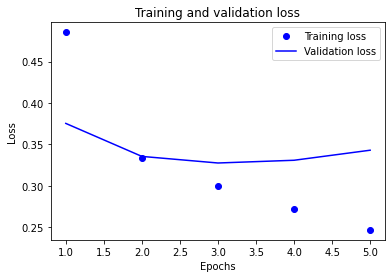

In [62]:
# epoch에 따른 training and validation loss 그래프 그리기

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 2) Accuracy 그래프 시각화

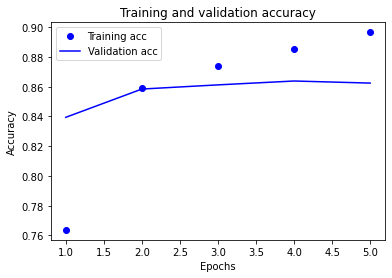

In [63]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [64]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


- 학습한 Embedding 파라미터 저장

In [65]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- Embedding 파라미터 확인

In [66]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']

In [67]:
# 워드 벡터가 의미벡터 공간 상에 유의미하게 학습되었는지 확인
# 단어와 그 단어와 유사한 단어와의 유사도 확인
word_vectors.similar_by_word("재미")

[('졸라', 0.7849285006523132),
 ('열라', 0.7596407532691956),
 ('가치', 0.7500051856040955),
 ('완전', 0.743036150932312),
 ('매우', 0.7384173274040222),
 ('브루스윌리스', 0.731959342956543),
 ('되게', 0.7205293774604797),
 ('이렇게', 0.7173727750778198),
 ('긴장감', 0.7144894003868103),
 ('노튼', 0.7111645936965942)]

## 1-D CNN 모델 사용

In [68]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성(1D-CNN)
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

### 4) 모델 학습

In [69]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
2206/2206 [==============================] - 39s 18ms/step - loss: 0.4368 - accuracy: 0.7798 - val_loss: 0.3368 - val_accuracy: 0.8572
Epoch 2/3
2206/2206 [==============================] - 32s 14ms/step - loss: 0.3155 - accuracy: 0.8658 - val_loss: 0.3197 - val_accuracy: 0.8644
Epoch 3/3
2206/2206 [==============================] - 32s 14ms/step - loss: 0.2686 - accuracy: 0.8896 - val_loss: 0.3233 - val_accuracy: 0.8660


### 5) 모델 평가

In [70]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3352 - accuracy: 0.8576
[0.3351723253726959, 0.857599139213562]


같은 epoch로 학습하였을 때, word2vec을 사용하면 아주 약간의 성능향상(0.5% 정도)이 발생함을 알 수 있었다. 학습 속도도 조금 더 빨라졌다. 

### 6) Loss, Accuracy 그래프 시각화

#### 1) Loss 그래프 시각화
아래의 그래프를 보면 

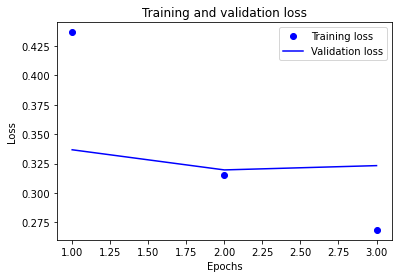

In [71]:
# epoch에 따른 training and validation loss 그래프 그리기

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 2) Accuracy 그래프 시각화

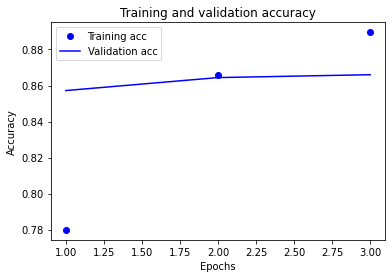

In [72]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [73]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


- 학습한 Embedding 파라미터 저장

In [74]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- Embedding 파라미터 확인

In [89]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']

In [76]:
# 워드 벡터가 의미벡터 공간 상에 유의미하게 학습되었는지 확인
# 단어와 그 단어와 유사한 단어와의 유사도 확인
word_vectors.similar_by_word("재미")

[('재미있', 0.518223762512207),
 ('재밌', 0.4977331757545471),
 ('긴장감', 0.4785453677177429),
 ('감동', 0.4520620107650757),
 ('웃음', 0.4379606246948242),
 ('매력', 0.4346483051776886),
 ('흥미', 0.43447327613830566),
 ('잼', 0.4284060597419739),
 ('웃기', 0.4268473982810974),
 ('한국인', 0.42577534914016724)]

## GlobalMaxPooling() 적용

In [77]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,011,361
Trainable params: 1,011,361
Non-trainable params: 0
_________________________________________________________________


### 4) 모델 학습

In [78]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
276/276 [==============================] - 3s 12ms/step - loss: 0.4283 - accuracy: 0.8031 - val_loss: 0.3326 - val_accuracy: 0.8570
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.3054 - accuracy: 0.8725 - val_loss: 0.3254 - val_accuracy: 0.8612
Epoch 3/3
276/276 [==============================] - 3s 12ms/step - loss: 0.2581 - accuracy: 0.8966 - val_loss: 0.3309 - val_accuracy: 0.8628


### 5) 모델 평가

In [79]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3397 - accuracy: 0.8591
[0.33971938490867615, 0.8591045141220093]


같은 epoch로 학습하였을 때, word2vec을 사용하면 대부분의 경우 아주 조금(1% 미만) 성능이 개선되었으나, 이번에는 정말 조금이지만 성능이 떨어졌다. 

### 6) Loss, Accuracy 그래프 시각화

#### 1) Loss 그래프 시각화

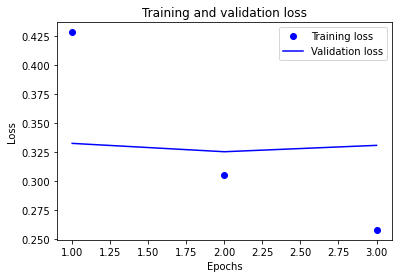

In [80]:
# epoch에 따른 training and validation loss 그래프 그리기

import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 2) Accuracy 그래프 시각화

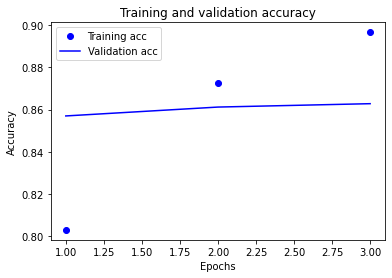

In [81]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [82]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


- 학습한 Embedding 파라미터 저장

In [83]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- Embedding 파라미터 확인

In [90]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']

In [85]:
# 워드 벡터가 의미벡터 공간 상에 유의미하게 학습되었는지 확인
# 단어와 그 단어와 유사한 단어와의 유사도 확인
word_vectors.similar_by_word("재미")

[('임팩트', 0.6432698369026184),
 ('긴장감', 0.613757312297821),
 ('깊이', 0.602951169013977),
 ('이리', 0.5572503805160522),
 ('원빈', 0.5318371057510376),
 ('의리', 0.5315841436386108),
 ('완전', 0.5240482687950134),
 ('몰입', 0.5167132019996643),
 ('잼', 0.5155214071273804),
 ('욱', 0.5147349834442139)]

## - 결과 비교
### 1) 정확도 비교
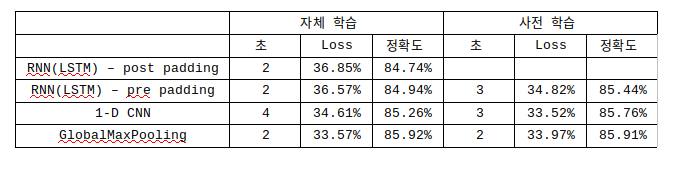
- 자체 학습 시에는 GlobalMaxPooling이 정확도가 제일 높았고, RNN의 정확도가 제일 낮았다. 학습 속도는 1-D CNN이 가장 느린 것으로 나오나, 대부분의 경우에는 1초로 가장 빨랐다. 
- 사전 학습의 경우에도 GlobalMaxPooling이 정확도가 제일 높았고, RNN의 정확도가 제일 낮았다. 
- 자체 학습과 사전 학습과의 비교를 해보면, 3가지의 모델 모두 자체 학습보다는 정확도가 높았으나, 예상보다는 많이 높지 않았다.
- 그러나 자체 학습과 사전 학습의 모든 모델의 정확도는 서로 비슷하여 별 차이가 없었다.

### 2) 임베딩 레이어 분석    
사전 학습 자체 학습과 사전 학습 모델의 정확도가 비슷하여 왜 그런지 gensim의 유사단어 찾기를 활용하여 임베딩을 비교하였다. 
- 재미의 경우
![](https://images.velog.io/images/guide333/post/1e2b40df-f5b4-4ff2-8026-fc53755191fe/Screenshot%20from%202021-01-21%2022-43-35.png)
'재미'의 경우, 사전 학습 모델이 유사도가 약간 높으나 자체 학습과도 별 차이가 없는 것 같다.      

- 영화의 경우
![](https://images.velog.io/images/guide333/post/b4ec29ee-c84f-4582-b9db-5ccfb2b66d23/Screenshot%20from%202021-01-21%2023-19-53.png)
'영화'의 경우도 단어 유사도가 그리 높지 않았다. 사전 학습 모델에서는 1-D CNN 외에는 단어별 유사도가 높지 않은 것으로 나타났다. 이런 이유로 자체 학습과 사전 학습 모델의 정확도가 별로 차이가 나지 않는 것 같다. 

# 후기
- 이번 프로젝트에서 어려웠던 점  
1. 파라미터 설정    
우선 모델을 설계할 때, 파라미터를 잘못 집어넣어 에러 메시지가 나왔다. 그 사실을 알아내기까지 너무 많은 시간을 낭비하였다. 
2. 모델 성능 개선      
처음부터 모델의 성능은 84~85% 정도에서 왔다갔다 했다. 사전 학습 모델로 임베딩했을 때, 자체 학습 모델과 성능이 아주 조금 개선되었다(1% 미만). 어떤 때는 도리어 성능이 떨어져서 이 문제를 해결하고자 다양한 시도를 했으나 별 성과는 없었다. 시도했던 방법들은 검증셋 크기 변화, 모델 변화, 불용어 추가 등이 있었다. 

- 프로젝트를 진행하면서 아직 모호한 점    
1. 모델 성능을 개선하기 위해서 무엇을 해야 하는지 잘 모르겠다. 여러 방법을 시도했으나 성능이 개선되지 않았다.
2. LMS에서 예상한 결과가 나오지 않는 점이 이상하다. 1-D CNN이 RNN보다 학습 속도가 빨라야 하는데, 이번에는 느리게 나왔다. 이전까지는 빨랐는데, 왜 느리게 변했는지 모르겠다. 


- 루브릭 평가 지표를 맞추기 위해 시도한 것들          
3가지 이상의 모델(RNN, 1-D CNN, GlobalMaxPooling)을 성공적으로 시도하였고, gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 분석하였다. 그러나 분석은 조금 부족한 것 같다. 네이버 영화리뷰 데이터 감성분석 정확도를 대부분 85% 이상 달성하였다.


- 자기 다짐        
이번 프로젝트는 정말 힘들었다. 평소보다 정말 많은 시간을 투자하였으나 만족할만한 결과가 나오지 않아 속상하다. 자연어처리가 이렇게 어려운 줄은 몰랐다. 그러나 어려운 만큼 자연어 처리 공부를 더 열심히 하고 싶다. 